Part II
-------

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy.constants as co
import scipy.stats as ss
import itertools
import pickle
from scipy import signal

In [2]:
# constants

# time for fast neutron to scatter enough times to fall to thermal energies
t_slow = 2.7e-6 # sec (2.7 us)

# time for thermal neutron to capture or decay (or otherwise be removed from consideration)
t_stop = 1e-5 # sec (100 us)

# approx room temperature
T = 298 # K (25 C)

# physical constants
k = co.physical_constants['Boltzmann constant in eV/K'][0] # Boltzmann constant in eV/K
B = 1/k/T # thermal energy constant [1/eV]
m_n = co.physical_constants['neutron mass energy equivalent in MeV'][0]*1e6 # neutron mass in eV
yr = 365*24*3600 # seconds per year
sealevel = 4/3600 # accepted neutron flux at sea level [cm^-2 s^-1]

In [3]:
# functions

def integrate_df(df):
    # (left-sided rectangular integral)
    dE = -df['E'].diff(periods = -1)
    dE.iat[-1] = dE.iat[-2]
    A = df['spec']*dE
    return A.sum()

def maxwell(E, B):
    # height of Maxwell distribution for energy E (eV) and temperature T (K) related to B via B = 1/kT
    return 2*B*np.sqrt(B*E/np.pi)*np.exp(-B*E)

In [4]:
# read in fast neutron flux spectrum (from reading_n_spectra.ipynb)
fast_flux_df = pd.read_pickle('data/FDF.txt') # 'E' in MeV, 'spec' in neutrons cm^-2 sec^-1 MeV^-1


#use numpy arrays
ff = np.asarray(fast_flux_df['E']);
ffspec = np.asarray(fast_flux_df['spec']);

In [5]:
#smooth the data
ffspec_smooth = signal.savgol_filter(ffspec, 501, 3) # window size 501, polynomial order 3

In [6]:
Es = np.geomspace(0.0001, 1e4, 2000)
Max = maxwell(Es, B)
snothermal = 4144.9/10000/86400
Therms = snothermal*Max

In [7]:
cutoff=0.3

ffhe = ff[ff>cutoff]
ffhespec = ffspec[ff>cutoff]

#smooth the data
ffhespec_smooth = signal.savgol_filter(ffhespec, 2001, 3) # window size 1001, polynomial order 3

ffle = ff[ff<=cutoff]
fflespec = ffspec[ff<=cutoff]
print(np.size(ffle))

#smooth the data
fflespec_smooth = signal.savgol_filter(fflespec, 75, 3) # window size 1001, polynomial order 3

175


In [8]:
# extrapolate line from lower-energy fast neutrons
E_thresh = 2e-2 # upper bound of linear region
E_therm = 0.15e-6 # near boundary of where thermal distribution has peak

fast_lin_df = ffle[ffle < E_thresh]
fast_lin_df_spec = fflespec_smooth[ffle< E_thresh]

In [9]:
fitted_line = ss.linregress(np.log(fast_lin_df), np.log(fast_lin_df_spec))
print(fitted_line)

LinregressResult(slope=-0.34198906017017205, intercept=-12.883178144228607, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.014824519476613129, intercept_stderr=0.06273875262265781)


In [10]:
def fast_extrapolation_line(E):
    # return height of fitted loglog line, if energy is larger than thermal threshold
    return np.exp(fitted_line.intercept + fitted_line.slope*np.log(E))*(E > E_therm)

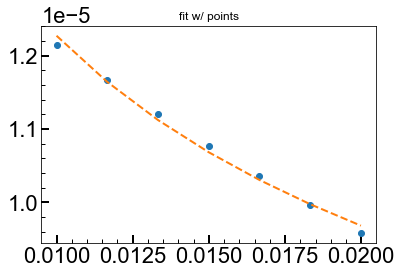

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('fit w/ points')
ax.plot(fast_lin_df, fast_lin_df_spec, 'o')
ax.plot(fast_lin_df, fast_extrapolation_line(fast_lin_df), linestyle = 'dashed')

In [12]:
Etherm = Es/1e6

print(np.size(Etherm),np.size(ffle),np.size(ffhe))
print(np.shape(Etherm))

2000 175 5825
(2000,)


In [13]:
etot = np.concatenate((Etherm,ffle,ffhe))
etot = np.unique(etot)
etotspec = np.zeros((np.size(etot),),dtype=np.float64)
print(np.size(etot),np.size(etotspec))

7999 7999


In [14]:
Therms_new = snothermal*Max + fast_extrapolation_line(Es/1e6)/1e6

In [15]:
etotspec[etot<=Etherm[-1]] = Therms_new*1e6
etotspec[(etot>Etherm[-1])&(etot<ffle[-5])] = fflespec_smooth[1:-5]
etotspec[(etot>ffle[-1])] = ffhespec_smooth
dee = etotspec>1.0e-9
etot = etot[dee]
etotspec = etotspec[dee]

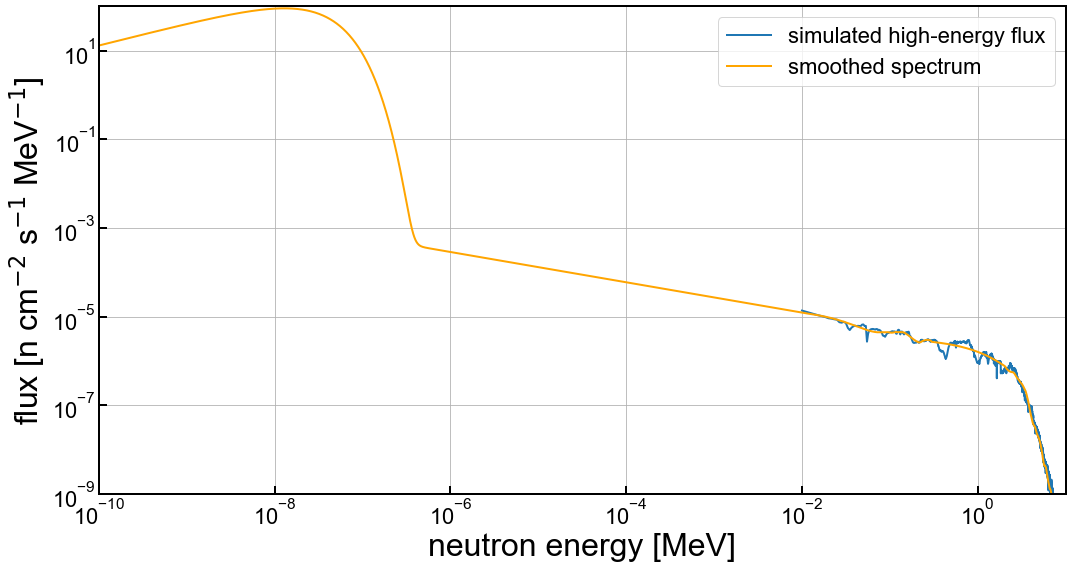

In [16]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(15.0,8.0),sharex=True)
ax1 = axes


#print(estring)
ax1.plot(ff, ffspec,label='simulated high-energy flux')
ax1.plot(etot, etotspec,color='orange',label="smoothed spectrum")



ymin = 1e-9
ymax = 100.0

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-10, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('flux [n cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

In [17]:
#get some cross section data
import ENDF6
f = open('data/jendl5_3He.endf6')
lines = f.readlines()
sec = ENDF6.find_section(lines, MF=3, MT=103)  # (N,P)
x, y = ENDF6.read_table(sec)

In [18]:
#densities to convert to macroscopic xn
rholhe3 = 0.0792 #g/cm^3
masshe3 = 3.016 #molar mass
nhe3 = (rholhe3/masshe3)*co.N_A

In [19]:
ESigMeV = x/1e6
SigMeV = y*1e-24*nhe3

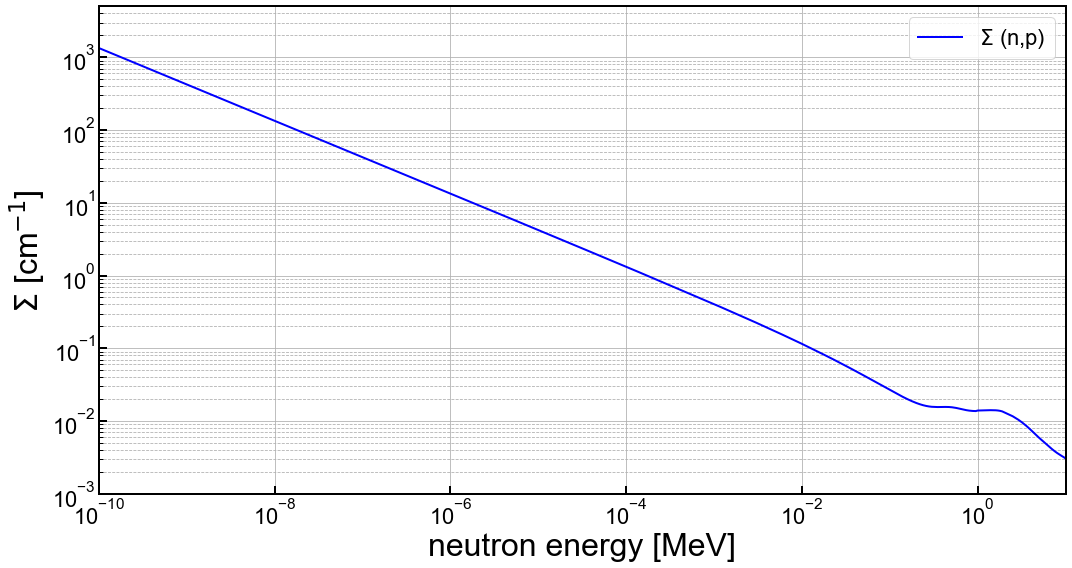

In [20]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(15.0,8.0),sharex=True)
ax1 = axes


#print(estring)
ax1.plot(ESigMeV, SigMeV,color='b',label="$\Sigma$ (n,p)")



ymin = 1e-3
ymax = 5e3

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-10, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('$\Sigma$ [cm$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

In [21]:
import scipy.interpolate as inter

flux = inter.InterpolatedUnivariateSpline(etot, etotspec , k=3)
sigma = inter.InterpolatedUnivariateSpline(ESigMeV, SigMeV , k=3)

In [22]:
print(flux(1.0))
print(sigma(1.0))

1.5956495747352664e-06
0.013933875302591645


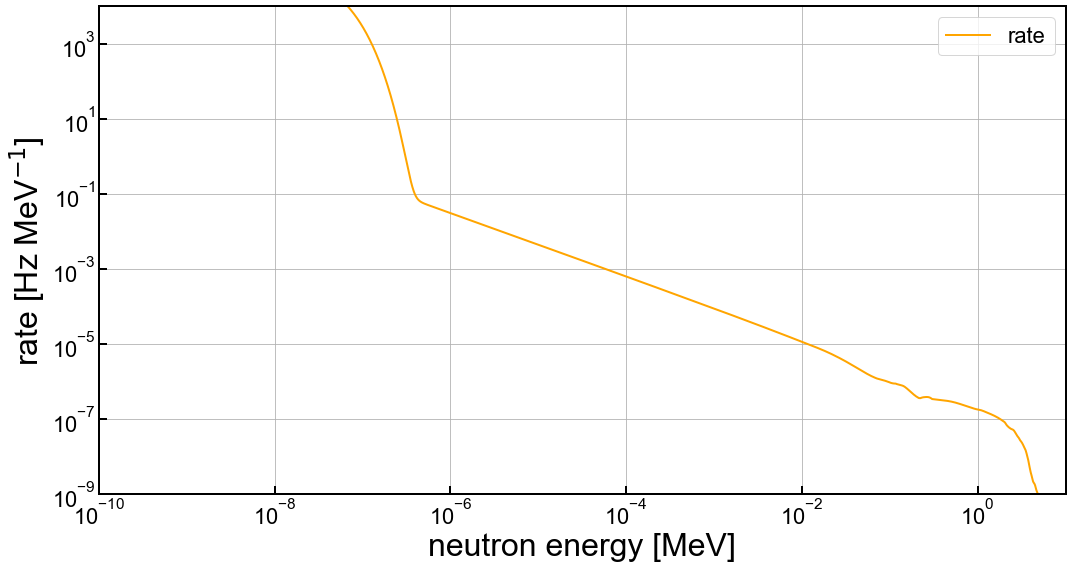

In [23]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(15.0,8.0),sharex=True)
ax1 = axes


#print(estring)
ax1.plot(etot, flux(etot)*sigma(etot)*8,color='orange',label="rate")



ymin = 1e-9
ymax = 1e4

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-10, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('rate [Hz MeV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

In [24]:
rt = pd.DataFrame()
erange = (etot>0.01)
rt['E']=etot[erange]
rt['spec']=flux(etot[erange])*sigma(etot[erange])*8
print(integrate_df(rt))

7.006774040954402e-07


In [25]:
print(f'SNOLAB counts above 10 keV in 1 yr = {integrate_df(rt)*60*60*24*365:1.2f} n cm^-2 s^-1')

SNOLAB counts above 10 keV in 1 yr = 22.10 n cm^-2 s^-1


In [26]:
rt = pd.DataFrame()
erange = (etot>0.001)
rt['E']=etot[erange]
rt['spec']=flux(etot[erange])*sigma(etot[erange])*8
print(integrate_df(rt))

9.511857837679633e-07


In [27]:
print(f'SNOLAB counts above 1 keV in 1 yr = {integrate_df(rt)*60*60*24*365:1.2f} n cm^-2 s^-1')

SNOLAB counts above 1 keV in 1 yr = 30.00 n cm^-2 s^-1


In [28]:
rt = pd.DataFrame()
erange = (etot>0.0)
rt['E']=etot[erange]
rt['spec']=flux(etot[erange])*sigma(etot[erange])*8
print(integrate_df(rt))

0.0036258741929924704


In [29]:
print(f'SNOLAB counts above 0 keV in 1 yr = {integrate_df(rt)*60*60*24*365:1.2f} n cm^-2 s^-1')

SNOLAB counts above 0 keV in 1 yr = 114345.57 n cm^-2 s^-1


Shielded Flux
-------------

(Below 1 keV)

In [30]:
rt_shield = pd.DataFrame()
erange = (etot<0.001)
rt_shield['E']=etot[erange]
rt_shield['spec']=flux(etot[erange])*0.5*4.0*6
print(integrate_df(rt_shield))

5.831734410289176e-05


In [31]:
print(f'SNOLAB counts below 1 keV in 1 yr = {integrate_df(rt_shield)*60*60*24*365:1.2f} n cm^-2 s^-1')

SNOLAB counts below 1 keV in 1 yr = 1839.10 n cm^-2 s^-1


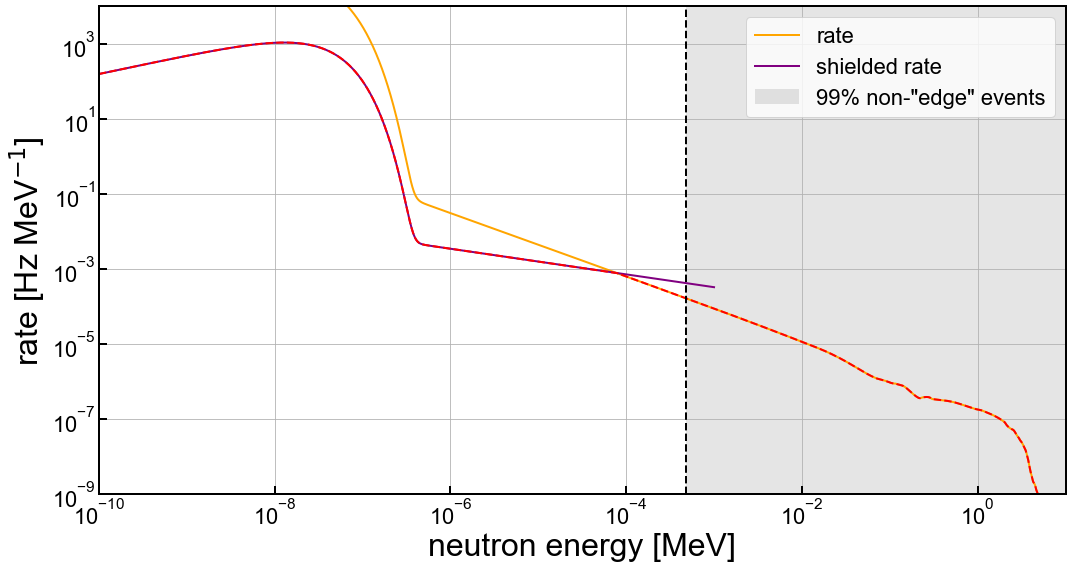

In [49]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(15.0,8.0),sharex=True)
ax1 = axes


#print(estring)
ax1.plot(etot, flux(etot)*sigma(etot)*8,color='orange',label="rate")
ax1.plot(etot[erange], flux(etot[erange])*0.5*4.0*6,color='purple',label="shielded rate")
ax1.plot(etot,np.minimum(flux(etot)*sigma(etot)*8,flux(etot)*0.5*4.0*6),color='r',linestyle="--",linewidth=2, \
         label='')

plt.axvline(x=0.0004774275004096884,color='k',linestyle="--")
plt.axvline(x=10,color='k',linestyle="--")
ax1.fill_between([0.0004774275004096884,10],[0,0],[50000,50000],facecolor='k',alpha=0.1,label='99% non-"edge" events')

ymin = 1e-9
ymax = 1e4

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-10, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('rate [Hz MeV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

Range
-----

In [33]:
prange_data = pd.read_csv("data/p-range-helium.txt", skiprows=8, names=['E [MeV]', 'CDSA range [g/cm2]','projected range'], \
                         delim_whitespace=True)
print (prange_data.head(10))

   E [MeV]  CDSA range [g/cm2]  projected range
0   0.0010            0.000005         0.000003
1   0.0015            0.000007         0.000004
2   0.0020            0.000009         0.000006
3   0.0025            0.000010         0.000007
4   0.0030            0.000012         0.000008
5   0.0040            0.000015         0.000011
6   0.0050            0.000017         0.000013
7   0.0060            0.000019         0.000015
8   0.0070            0.000021         0.000017
9   0.0080            0.000023         0.000019


In [34]:
T = np.asarray(prange_data['E [MeV]'])
Tcut = (T<0.85)&(T>0.7)

In [35]:
R = np.asarray(prange_data['CDSA range [g/cm2]'])
Rproj = np.asarray(prange_data['projected range'])

In [36]:
print(R[Tcut]/rholhe3)
print(Rproj[Tcut]/rholhe3)
print(T[Tcut])

[0.01699495 0.01883838]
[0.01690657 0.01875   ]
[0.75 0.8 ]


In [37]:
print(np.exp(-sigma(T[Tcut]-0.7499953)*R[Tcut]/rholhe3))

[0.90058652 0.9991989 ]


In [38]:
print((T[Tcut]-0.7499953))

[4.70000e-06 5.00047e-02]


In [39]:
zero = lambda E: np.exp(-sigma(0.75-E)*0.01699495)-0.90
import scipy.optimize as so

print(so.brentq(zero,0,1,rtol=0.0000001,maxiter=100))
print(0.750-so.brentq(zero,0,1,rtol=0.0000001,maxiter=100))

0.7499953670860332
4.632913966795549e-06


In [41]:
zero99 = lambda E: np.exp(-sigma(0.75-E)*0.01699495)-0.99

print(so.brentq(zero99,0,1,rtol=0.0000001,maxiter=100))
print(0.750-so.brentq(zero99,0,1,rtol=0.0000001,maxiter=100))

0.7495225724995903
0.0004774275004096884
